## This Notebook will aim to Optimize Random Forrest


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)

# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')

df = pd.concat([train,val,test])

In [2]:
#df= df.iloc[:,:100]

In [3]:

# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')


In [4]:


preprocessor = DataPreprocessor(df)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR','Gaming_category']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',

input = df[['Ever90'] +list(all_features) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)


In [5]:
# pd.set_option('display.max_columns', None)

# git add .

# git commit -m "Finalised API Loop"

#  git status

#  git push origin Andreas

In [6]:
train

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,2022-11-21,8472026,0,7202121708,2022-11-24,500000,0,2,1,0,...,23872.0,165.2,47.0,117.4,153.1,321626,16749,108869,217967,0
2368,2023-04-22,8651069,0,8201027912,2023-05-02,300000,1,1,1,1,...,16930.0,133.1,95.0,142.3,136.2,223432,36201,74311,153202,0
2369,2022-11-14,8462708,0,9501047311,2022-11-21,500000,0,2,1,0,...,140.9,218.6,233.7,528243.0,85423.0,256788,482350,0,0,0
2370,2022-12-30,8516099,0,9711303983,2023-01-05,500000,1,1,1,0,...,269.3,236.8,376.6,860834.0,119665.0,246092,641294,0,0,0


In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()




Final model Gini coefficient: 0.8488


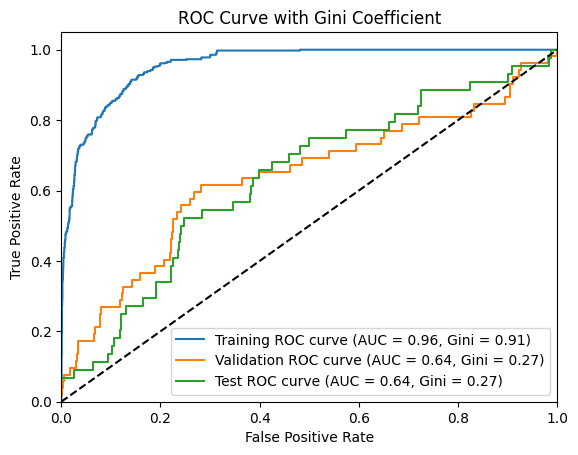

In [8]:


# Define the Random Forest classifier
rf = RandomForestClassifier(
    criterion='gini', 
    random_state=42,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=4,
    n_estimators=60
)


# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(all_features)[rfecv.support_]


# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature sete
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())


# Transform the test set using RFECV

X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]



## reduce 

Final model Gini coefficient: 0.8449


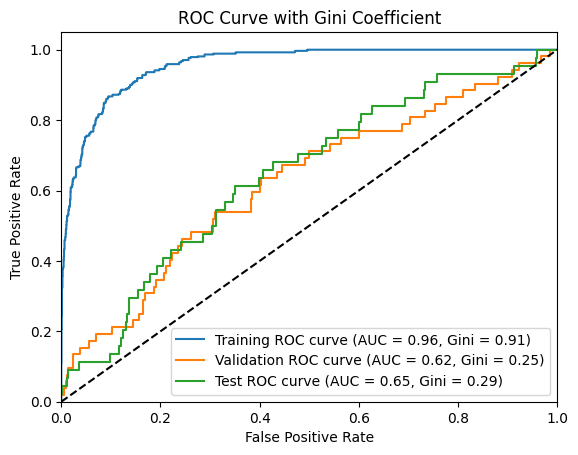

In [9]:

# preprocessor = DataPreprocessor(df)

# all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',

# input = df[['Ever90'] +list(all_features) ]

# ## Scalle
# (Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)



forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]


# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())


# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]



Optimal number of features: 161
Best features: ['avg_CashWithdrawal' 'avg_DebtCollection' 'avg_Deposit' 'avg_Gambling'
 'avg_Gaming' 'avg_HousingCost' 'avg_InstallmentPayment' 'avg_Loan'
 'avg_MobilePayment' 'avg_OtherIncome' 'avg_Salary'
 'avg3Months_CashWithdrawal' 'avg3Months_DebtCollection'
 'avg3Months_Deposit' 'avg3Months_Gambling' 'avg3Months_Gaming'
 'avg3Months_InstallmentPayment' 'avg3Months_Loan'
 'avg3Months_MobilePayment' 'avg3Months_Salary'
 'avg6Months_CashWithdrawal' 'avg6Months_DebtCollection'
 'avg6Months_Deposit' 'avg6Months_Gambling' 'avg6Months_Gaming'
 'avg6Months_HousingCost' 'avg6Months_InstallmentPayment'
 'avg6Months_Loan' 'avg6Months_MobilePayment' 'avg6Months_Salary'
 'count_CashWithdrawal' 'count_Deposit' 'count_Gambling' 'count_Gaming'
 'count_InstallmentPayment' 'count_Loan' 'count_MobilePayment'
 'count_OtherIncome' 'count_PassiveIncome' 'count_Salary'
 'sum_CashWithdrawal' 'sum_DebtCollection' 'sum_Deposit' 'sum_Gambling'
 'sum_HousingCost' 'sum_Install

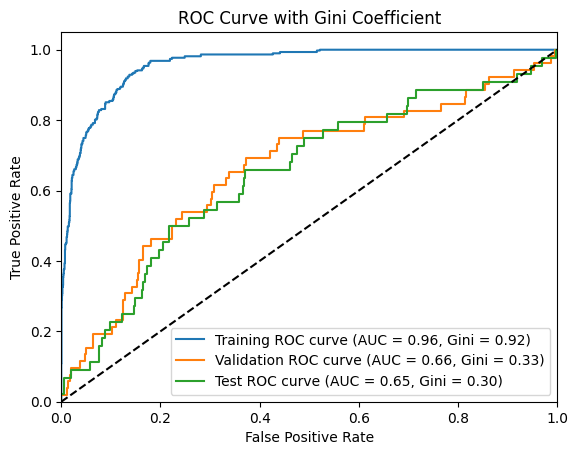

In [10]:

forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())


# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


Optimal number of features: 149
Best features: ['avg_CashWithdrawal' 'avg_DebtCollection' 'avg_Deposit' 'avg_Gambling'
 'avg_Gaming' 'avg_HousingCost' 'avg_InstallmentPayment' 'avg_Loan'
 'avg_MobilePayment' 'avg_Salary' 'avg3Months_CashWithdrawal'
 'avg3Months_DebtCollection' 'avg3Months_Deposit' 'avg3Months_Gambling'
 'avg3Months_Gaming' 'avg3Months_InstallmentPayment' 'avg3Months_Loan'
 'avg3Months_MobilePayment' 'avg3Months_Salary'
 'avg6Months_CashWithdrawal' 'avg6Months_DebtCollection'
 'avg6Months_Deposit' 'avg6Months_Gambling' 'avg6Months_Gaming'
 'avg6Months_HousingCost' 'avg6Months_InstallmentPayment'
 'avg6Months_Loan' 'avg6Months_MobilePayment' 'avg6Months_Salary'
 'count_CashWithdrawal' 'count_Deposit' 'count_Gambling' 'count_Gaming'
 'count_InstallmentPayment' 'count_Loan' 'count_MobilePayment'
 'count_OtherIncome' 'count_PassiveIncome' 'count_Salary'
 'sum_CashWithdrawal' 'sum_DebtCollection' 'sum_Deposit' 'sum_Gambling'
 'sum_HousingCost' 'sum_InstallmentPayment' 'sum_L

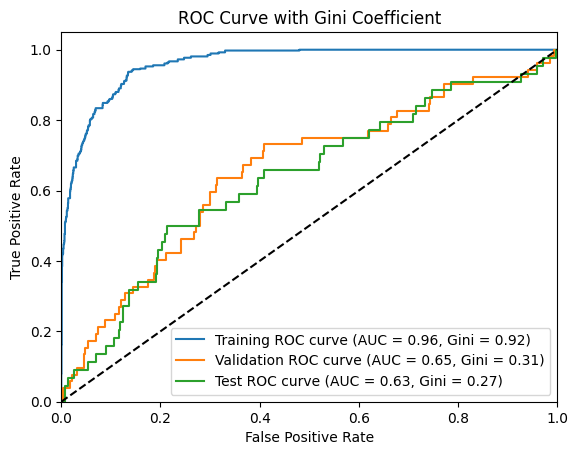

In [11]:

forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)


# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())


# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


Optimal number of features: 130
Best features: ['avg_CashWithdrawal' 'avg_DebtCollection' 'avg_Deposit' 'avg_Gambling'
 'avg_HousingCost' 'avg_InstallmentPayment' 'avg_Loan' 'avg_MobilePayment'
 'avg_Salary' 'avg3Months_CashWithdrawal' 'avg3Months_DebtCollection'
 'avg3Months_Deposit' 'avg3Months_Gaming' 'avg3Months_InstallmentPayment'
 'avg3Months_Loan' 'avg3Months_MobilePayment' 'avg3Months_Salary'
 'avg6Months_CashWithdrawal' 'avg6Months_DebtCollection'
 'avg6Months_Deposit' 'avg6Months_Gambling' 'avg6Months_HousingCost'
 'avg6Months_InstallmentPayment' 'avg6Months_Loan'
 'avg6Months_MobilePayment' 'avg6Months_Salary' 'count_CashWithdrawal'
 'count_Deposit' 'count_Gambling' 'count_Gaming'
 'count_InstallmentPayment' 'count_Loan' 'count_MobilePayment'
 'count_PassiveIncome' 'count_Salary' 'sum_CashWithdrawal'
 'sum_DebtCollection' 'sum_Deposit' 'sum_Gambling' 'sum_HousingCost'
 'sum_Loan' 'sum_Salary' 'trend_DebtCollection' 'trend_Deposit'
 'trend_Gambling' 'trend_Gaming' 'trend_Inst

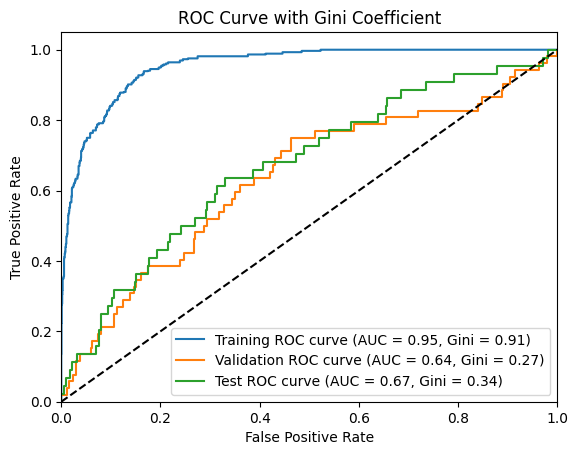

In [12]:

forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)

# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)
print("Final model Gini coefficient: %0.4f" % final_score.mean())


# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


In [14]:
stagnated = sorted_features
stagnated

array(['avg6Months_Loan', 'avg_Loan', 'sum_Loan',
       'Unclassified_sum3Months', 'count_Loan', 'avg6Months_Salary',
       'avg_Salary', 'sum installmentPayments', 'avg3Months_Loan',
       'avg3Months_CashWithdrawal', 'DebtCollection_sum3Months',
       'avg6Months_CashWithdrawal', 'trend_Gaming', 'avg3Months_Deposit',
       'Gambling_sum9Months', 'InstallmentPayment_partOfSalary3Months',
       'trend_DebtCollection', 'DebtCollection_sum12Months',
       'CashWithdrawal_sum6Months', 'Gaming_count3Months',
       'trend_Deposit', 'CashWithdrawal_partOfSalary9Months',
       'count_MobilePayment', 'InstallmentPayment_partOfSalary6Months',
       'DebtCollection_sum9Months', 'sum_Gambling', 'avg_Gambling',
       'sum_Salary', 'trend_Salary', 'Gaming_partOfSalary12Months',
       'CashWithdrawal_partOfSalary3Months', 'Gaming_count6Months',
       'avg3Months_MobilePayment', 'MobilePayment_count12Months',
       'HousingCost_category', 'MobilePayment_partOfSalary6Months',
       'Mob

## reduce dataset manually just ot se

Optimal number of features: 78
Best features: ['avg6Months_Loan' 'avg_Loan' 'sum_Loan' 'Unclassified_sum3Months'
 'count_Loan' 'avg6Months_Salary' 'avg_Salary' 'sum installmentPayments'
 'avg3Months_Loan' 'avg3Months_CashWithdrawal' 'DebtCollection_sum3Months'
 'avg6Months_CashWithdrawal' 'trend_Gaming' 'avg3Months_Deposit'
 'Gambling_sum9Months' 'InstallmentPayment_partOfSalary3Months'
 'trend_DebtCollection' 'DebtCollection_sum12Months'
 'CashWithdrawal_sum6Months' 'Gaming_count3Months' 'trend_Deposit'
 'CashWithdrawal_partOfSalary9Months' 'count_MobilePayment'
 'InstallmentPayment_partOfSalary6Months' 'DebtCollection_sum9Months'
 'sum_Gambling' 'avg_Gambling' 'sum_Salary' 'trend_Salary'
 'Gaming_partOfSalary12Months' 'CashWithdrawal_partOfSalary3Months'
 'Gaming_count6Months' 'avg3Months_MobilePayment'
 'MobilePayment_count12Months' 'HousingCost_category'
 'MobilePayment_partOfSalary6Months' 'MobilePayment_monthlyAvg'
 'InstallmentPayment_sum3Months' 'trend_MobilePayment'
 'avg6Mont

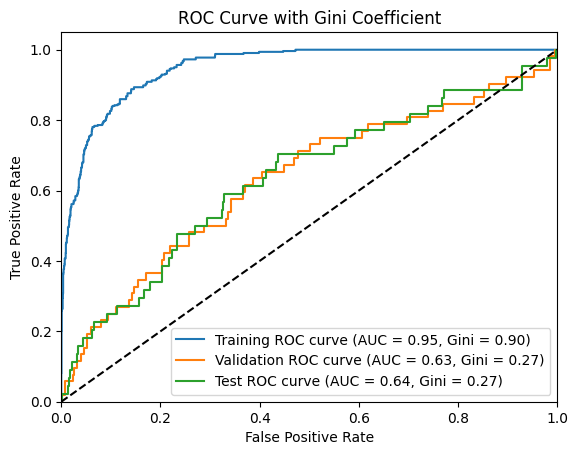

In [15]:
optimal_features = stagnated[:80]


forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)
# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)



# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


Optimal number of features: 49
Best features: ['avg6Months_Loan' 'avg_Loan' 'sum_Loan' 'Unclassified_sum3Months'
 'count_Loan' 'avg6Months_Salary' 'avg_Salary' 'sum installmentPayments'
 'avg3Months_Loan' 'avg3Months_CashWithdrawal' 'DebtCollection_sum3Months'
 'avg6Months_CashWithdrawal' 'trend_Gaming' 'avg3Months_Deposit'
 'Gambling_sum9Months' 'InstallmentPayment_partOfSalary3Months'
 'trend_DebtCollection' 'DebtCollection_sum12Months'
 'CashWithdrawal_sum6Months' 'Gaming_count3Months' 'trend_Deposit'
 'CashWithdrawal_partOfSalary9Months' 'count_MobilePayment'
 'InstallmentPayment_partOfSalary6Months' 'DebtCollection_sum9Months'
 'sum_Gambling' 'avg_Gambling' 'sum_Salary' 'trend_Salary'
 'Gaming_partOfSalary12Months' 'CashWithdrawal_partOfSalary3Months'
 'Gaming_count6Months' 'avg3Months_MobilePayment'
 'MobilePayment_count12Months' 'HousingCost_category'
 'MobilePayment_partOfSalary6Months' 'MobilePayment_monthlyAvg'
 'InstallmentPayment_sum3Months' 'trend_MobilePayment'
 'avg6Mont

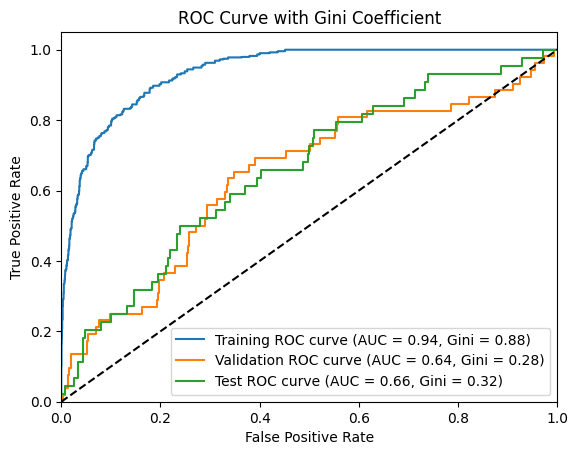

In [16]:
optimal_features = stagnated[:50]


forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)
# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)



# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


Optimal number of features: 34
Best features: ['avg6Months_Loan' 'avg_Loan' 'sum_Loan' 'Unclassified_sum3Months'
 'count_Loan' 'avg6Months_Salary' 'avg_Salary' 'sum installmentPayments'
 'avg3Months_Loan' 'avg3Months_CashWithdrawal' 'DebtCollection_sum3Months'
 'avg6Months_CashWithdrawal' 'trend_Gaming' 'avg3Months_Deposit'
 'Gambling_sum9Months' 'InstallmentPayment_partOfSalary3Months'
 'trend_DebtCollection' 'DebtCollection_sum12Months'
 'CashWithdrawal_sum6Months' 'Gaming_count3Months' 'trend_Deposit'
 'CashWithdrawal_partOfSalary9Months' 'count_MobilePayment'
 'InstallmentPayment_partOfSalary6Months' 'DebtCollection_sum9Months'
 'sum_Gambling' 'avg_Gambling' 'sum_Salary' 'trend_Salary'
 'Gaming_partOfSalary12Months' 'CashWithdrawal_partOfSalary3Months'
 'Gaming_count6Months' 'avg3Months_MobilePayment' 'HousingCost_category']


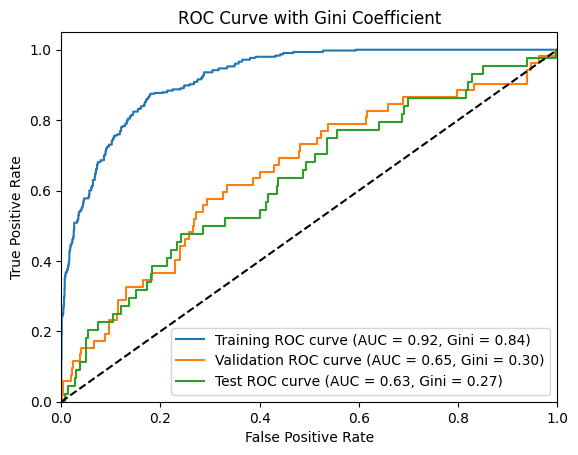

In [18]:
optimal_features = stagnated[:35]


forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)
# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)



# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


Optimal number of features: 36
Best features: ['avg6Months_Loan' 'avg_Loan' 'sum_Loan' 'Unclassified_sum3Months'
 'count_Loan' 'avg6Months_Salary' 'avg_Salary' 'sum installmentPayments'
 'avg3Months_Loan' 'avg3Months_CashWithdrawal' 'DebtCollection_sum3Months'
 'avg6Months_CashWithdrawal' 'trend_Gaming' 'avg3Months_Deposit'
 'Gambling_sum9Months' 'InstallmentPayment_partOfSalary3Months'
 'trend_DebtCollection' 'DebtCollection_sum12Months'
 'CashWithdrawal_sum6Months' 'Gaming_count3Months' 'trend_Deposit'
 'CashWithdrawal_partOfSalary9Months' 'count_MobilePayment'
 'InstallmentPayment_partOfSalary6Months' 'DebtCollection_sum9Months'
 'sum_Gambling' 'avg_Gambling' 'sum_Salary' 'trend_Salary'
 'Gaming_partOfSalary12Months' 'CashWithdrawal_partOfSalary3Months'
 'Gaming_count6Months' 'avg3Months_MobilePayment'
 'MobilePayment_count12Months' 'HousingCost_category'
 'MobilePayment_partOfSalary6Months']


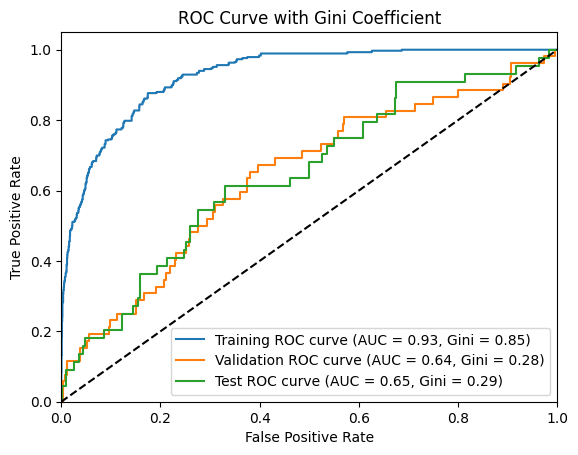

In [27]:
optimal_features = stagnated[:36]


forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
print("Optimal number of features: %d" % rfecv.n_features_)
print("Best features: %s" % optimal_features)
# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)



# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


## Save the model Abouve

In [28]:
import joblib

path = "../../2. Python/Finished Models"
os.chdir(path)


In [29]:
os.getcwd()

'/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/PSD2-Data-Engineering-Modeling-DATA-258-1/2. Python/Finished Models'

In [30]:

# Save the model and features
joblib.dump(rf, os.path.join( 'rf_model_1.pkl'))

joblib.dump(optimal_features, os.path.join('optimal_features_rf_model_1.pkl'))

print("Model and features have been saved to Python/Finished Models.")

Model and features have been saved to Python/Finished Models.


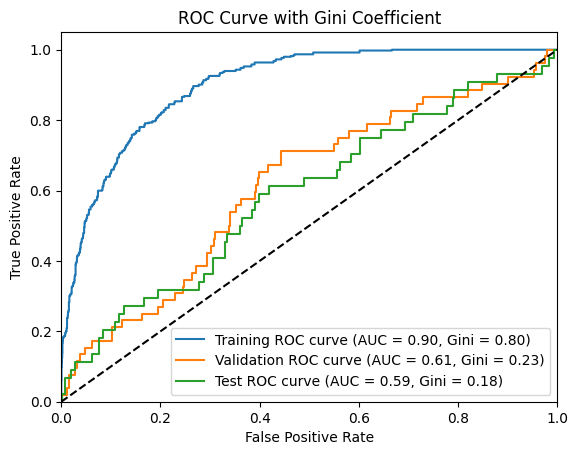

In [19]:
optimal_features = stagnated[:20]


forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
# print("Optimal number of features: %d" % rfecv.n_features_)
# print("Best features: %s" % optimal_features)
# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)



# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]


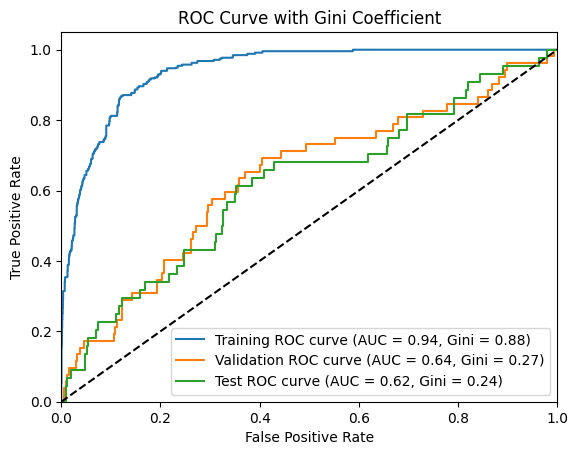

In [20]:
optimal_features = stagnated[:80]


forforsta = df[['Ever90']+list(optimal_features)]


# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the RFECV object for recursive feature elimination with cross-validation
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring=gini_score, n_jobs=-1)

# Perform RFECV on the resampled data
rfecv.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(list(optimal_features))[rfecv.support_]
# print("Optimal number of features: %d" % rfecv.n_features_)
# print("Best features: %s" % optimal_features)
# Transform the dataset to the optimal feature set
X_optimal = rfecv.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
rf.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(rf, X_optimal, Ytrain_resampled, cv=3, scoring=gini_score)



# Transform the test set using RFECV
X_train_optimal = rfecv.transform(Xtrain)
X_val_optimal = rfecv.transform(Xval)
X_test_optimal = rfecv.transform(Xtest)

# Plot for both the training and val sets
plot_gini(rf, X_optimal, Ytrain_resampled, X_val_optimal, Yval,  X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")

# Get feature importances
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = optimal_features[sorted_indices]
